# License 
***
Copyright 2017 J. Patrick Hall, phall@h2o.ai & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Sensitivity Analysis
***

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 07 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,2 months and 11 days
H2O cluster name:,H2O_from_python_phall_vocuai
H2O cluster total nodes:,1
H2O cluster free memory:,3.545 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [3]:
# load data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### Impute missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7], seed=12345)

## Train a predictive model

In [7]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X, training_frame=train, validation_frame=valid)

preds = valid.cbind(model.predict(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Determine important variables for use in sensitivity analysis

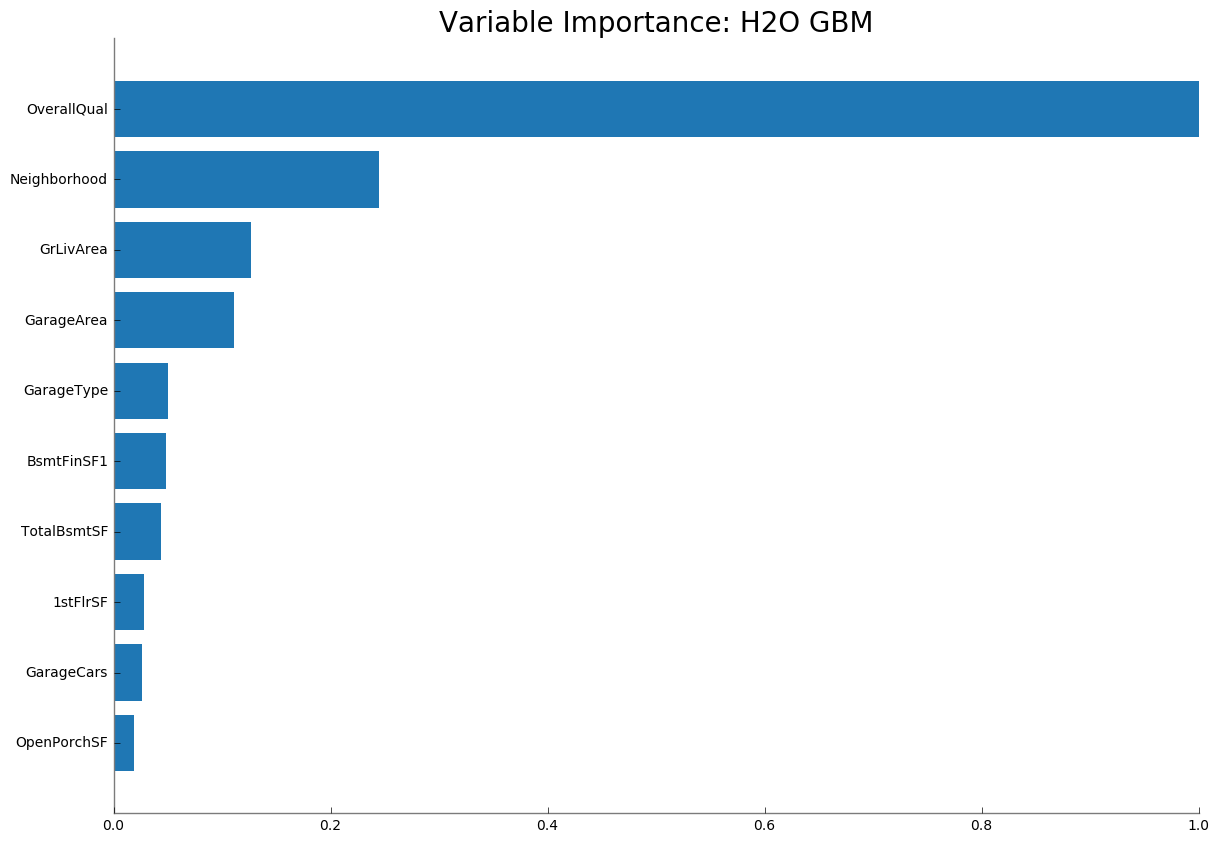

In [8]:
model.varimp_plot()

#### Helper function for finding quantile indices

In [9]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

sale_quantile_dict = get_quantile_dict('SalePrice', 'Id', preds)
pred_quantile_dict = get_quantile_dict('predict', 'Id', preds)

print('SalePrice quantiles:\n', sale_quantile_dict)
print('prediction quantiles:\n',pred_quantile_dict)

SalePrice quantiles:
 {0: 534, 80: 148, 50: 348, 99: 770, 20: 1137, 70: 1441, 40: 1369, 10: 1136, 60: 488, 90: 818, 30: 1114}
prediction quantiles:
 {0: 534, 80: 471, 50: 270, 99: 225, 20: 873, 70: 488, 40: 1351, 10: 69, 60: 392, 90: 641, 30: 1130}


#### Get validation data ranges

In [10]:
print('lowest SalePrice:\n', preds[preds['Id'] == int(sale_quantile_dict[0])]['SalePrice'])
print('lowest prediction:\n', preds[preds['Id'] == int(pred_quantile_dict[0])]['predict'])
print('highest SalePrice:\n', preds[preds['Id'] == int(sale_quantile_dict[99])]['SalePrice'])
print('highest prediction:\n', preds[preds['Id'] == int(pred_quantile_dict[99])]['predict'])

lowest SalePrice:
 

SalePrice
39300



lowest prediction:
 

predict
65629.6



highest SalePrice:
 

SalePrice
538000



highest prediction:
 

predict
440843


This result alone is interesting. The model appears to be struggling to accurately predict low and high values for SalePrice. This behavior should be corrected to increase the accuracy of predictions. A strategy for improving predictions for these homes with extreme values might be to weight them higher during training using observation weights, or they may need their own models.

## Now use trained model to test predictions for interesting situations

#### How will the model handle making the home with the lowest predicted price even less desirable?

In [11]:
# look at current row
print(preds[preds['Id'] == int(pred_quantile_dict[0])])

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,predict
534,20,RL,50,5000,Pave,NA,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0,Fa,Fa,Slab,NA,NA,NA,NA,0,NA,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NA,NA,1978.51,NA,0,0,NA,NA,N,0,0,0,0,0,0,NA,NA,NA,0,1,2007,WD,Normal,39300,65629.6


In [12]:
# find current error
observed = preds[preds['Id'] == int(pred_quantile_dict[0])]['SalePrice'][0,0]
predicted = preds[preds['Id'] == int(pred_quantile_dict[0])]['predict'][0,0]
print('Error: %.2f%%' % (100*(abs(observed - predicted)/observed)))

Error: 67.00%


In [13]:
# change value of important variables
test_case = preds[preds['Id'] == int(pred_quantile_dict[0])]
test_case = test_case.drop('predict')
test_case['OverallQual'] = 0
test_case['Neighborhood'] = 'IDOTRR'
test_case['GrLivArea'] = 500
test_case = test_case.cbind(model.predict(test_case))
print(test_case)

# recalculate error
observed = test_case['SalePrice'][0,0]
predicted = test_case['predict'][0,0]
print('Error: %.2f%%' % (100*(abs(observed - predicted)/observed)))

gbm prediction progress: |████████████████████████████████████████████████| 100%


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,predict
534,20,RL,50,5000,Pave,NA,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,0,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0,Fa,Fa,Slab,NA,NA,NA,NA,0,NA,0,0,0,GasA,Fa,N,FuseF,334,0,0,500,0,0,1,0,1,1,Fa,2,Typ,0,NA,NA,1978.51,NA,0,0,NA,NA,N,0,0,0,0,0,0,NA,NA,NA,0,1,2007,WD,Normal,39300,50466



Error: 28.41%


While the model does not seem to handle low-valued homes very well, making the home with the lowest predicted price less appealling does not seem to make the model's predictions any worse. While this prediction behavior appears somewhat stable, which would normally be desirable, this is not particularly good news as the underlying prediction is so inaccurate. 

#### How will the model handle making the home with the highest predicted price even more desirable?

In [14]:
# look at current row
print(preds[preds['Id'] == int(pred_quantile_dict[99])])

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,predict
225,20,RL,103,13472,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922,Ex,TA,PConc,Ex,TA,Gd,GLQ,56,Unf,0,2336,2392,GasA,Ex,Y,SBrkr,2392,0,0,2392,0,0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003,Fin,3,968,TA,TA,Y,248,105,0,0,0,0,NA,NA,NA,0,6,2009,WD,Normal,386250,440843


In [15]:
# find current error
observed = preds[preds['Id'] == int(pred_quantile_dict[99])]['SalePrice'][0,0]
predicted = preds[preds['Id'] == int(pred_quantile_dict[99])]['predict'][0,0]
print('Error: %.2f%%' % (100*(abs(observed - predicted)/observed)))

Error: 14.13%


In [16]:
# change value of important variables
test_case = preds[preds['Id'] == int(pred_quantile_dict[99])]
test_case = test_case.drop('predict')
test_case['Neighborhood'] = 'StoneBr'
test_case['GrLivArea'] = 5000
test_case = test_case.cbind(model.predict(test_case))
print(test_case)

# recalculate error
observed = test_case['SalePrice'][0,0]
predicted = test_case['predict'][0,0]
print('Error: %.2f%%' % (100*(abs(observed - predicted)/observed)))

gbm prediction progress: |████████████████████████████████████████████████| 100%


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,predict
225,20,RL,103,13472,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922,Ex,TA,PConc,Ex,TA,Gd,GLQ,56,Unf,0,2336,2392,GasA,Ex,Y,SBrkr,2392,0,0,5000,0,0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003,Fin,3,968,TA,TA,Y,248,105,0,0,0,0,NA,NA,NA,0,6,2009,WD,Normal,386250,478120



Error: 23.78%


This result may point to unstable predictions for the higher end of SalesPrice.

#### Shutdown H2O

In [17]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_b43f closed.
